# Modeling the COVID-19 Pandemic

## Reading

1. Murray, C.J.L., and IHME COVID-19 health service utilization forecasting team, 2020. Forecasting COVID-19 impact on hospital bed-days, ICU-days, ventilator-days and deaths by US state in the next 4 months,
https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1.full-text

1. Jewell, N.P.,  J.A. Lewnard,  and B.L. Jewell, 2020.
Predictive Mathematical Models of the COVID-19 Pandemic: Underlying Principles and Value of Projections,
_JAMA_, 323(19):1893-1894. doi:10.1001/jama.2020.6585

1. Froese, H., 2020. Infectious Disease Modelling: Fit Your Model to Coronavirus Data, Towards Data Science, https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7; https://github.com/henrifroese/infectious_disease_modelling 

1. Smith, D., and L. Moore, 2004. The SIR model for spread of disease, _Convergence_, https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-introduction



# SIR models

Simplest model of contagion and recovery. 
It ignores births, immigration, emigration, deaths from other causes, carriers, population heterogeneity, geography,
population mixing, etc.

Here are the state variables:

+ $N$: initial population size
+ $S(t)$: number of susceptible individuals in the population at time $t$
+ $I(t)$: number of infected individuals in the population at time $t$
+ $R(t)$: number dead or recovered in the population at time $t$

Assumptions:

+ Everyone is either susceptible, infected, recovered, or dead. (There are more complex models with more "compartments.")
+ There are no births, immigration, emigration, or deaths from other causes.
+ If a susceptible person is infected, that person eventually dies or recovers. 
+ While a person is infected, the person is infectious.
+ There is no "incubation period" between being infected and being infectious.
+ If a susceptible person recovers, that person becomes immune (not susceptible) and is no longer infectious.
+ If an infected person gets "close enough" to a susceptible person, the susceptible person becomes infected.
+ Every unit of time, every infected person gets close enough to $\beta$ people to infect any of them who are susceptible. Ignore the possibility that two or more infected people get close to the same susceptible person.
+ Every unit of time, a fraction $\gamma$ of infected people recover or die.

Then $S + I + R = N$ is constant, the initial population size.

The basic reproductive number $R_0 = \beta/\gamma$ is the number of people each infected person infects before recovering or dying. Note that this interpretation depends on the assumption that, initially, essentially the entire population is susceptible (the proportion who are infected or recovered is small compared to $N$).
(Also note that $R_0$ has no connection to $R$: the notation is unfortunate.)

Define $s(t) \equiv S(t)/N$, $i(t) \equiv I(t)/N$, and $r(t) \equiv R(t)/N$.
Then $s+i+r = 1$ for all $t$.

The parameters of the model are:

+ $\beta$, the number of exposed people per unit of time per infected persion
+ $\gamma$, the fraction of infected people who recover (or die) per unit time

The state of the population evolves according to three coupled differential equations:

+ $dS/dt = -\beta I S/N$
+ $dI/dt = \beta I S/N - \gamma I$ (equivalently, $di/dt = \beta is - \gamma i$)
+ $dR/dt = \gamma I$

Another interesting variable is the cumulative number of infections, $C$.

+ $dC/dt = \beta I S/N$; $C(0) = I(0)$.

We will also consider what happens if immunity wears off over time, which we parametrize as a fraction $\delta$ of $R$ returning to $S$ in each time period. That yields:

+ $dS/dt = -\beta I S/N + \delta R$
+ $dI/dt = \beta I S/N - \gamma I$ (equivalently, $di/dt = \beta is - \gamma i$)
+ $dR/dt = \gamma I - \delta R$

(There are other ways we could do this, for instance, having a variable "lag" between recovery and becoming susceptible again.)

Other generalizations include separate "compartments" for dead versus recovered, for needing an ICU bed, etc., as well as time-varying values of $\beta$ to account for lockdowns, heterogeneity in the population, and more.

Let's run this model (in discrete time) for a population of $N=1,000,000$ people of whom 0.05% are initially infected.
We will take the time interval to be 1 day, the period of infectiousness to be $1/\gamma = 14$ days,
and $R_0 = 2 = \beta/\gamma$, so $\beta = 2 \gamma = 1/7$. We will start with $\delta=0$ (no re-infections).

In [1]:
# boilerplate
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML

In [2]:
def sir_model(N, i_0, beta=1, gamma=1, delta=0, steps=365):
    '''
    Run SIR model as finite-difference equations. Assumes that initially a fraction i_0 of
    the population of N people is infected and everyone else is susceptible (none has died or
    recovered).
    
    Parameters
    -----------
    N   :   int
        population size
    i_0 :   double in (0, 1)
        initial fraction of population infected
    beta :  double in [0, infty)
        number of encounters each infected person has per time step
    gamma : double in (0, 1)
        fraction of infecteds who recover or die per time step
    delta : double in (0, 1)
        fraction of recovereds who become susceptible per time step
    
    Returns
    --------
    S, I, R 
    S     : list
        time history of susceptibles
    I     : list
        time history of infecteds
    R     : list
        time history of recovered/dead    
    I_tot : list
        cumulative number of infections over time
    '''
    assert i_0 > 0, 'initial rate of infection is zero'
    assert i_0 <= 1, 'infection rate greater than 1'
    assert beta >= 0, 'beta must be nonnegative'
    assert gamma > 0, 'gamma must be positive'
    assert gamma < 1, 'gamma must be less than 1'
    S = np.zeros(steps)
    I = np.zeros(steps)
    R = np.zeros(steps)
    C = np.zeros(steps)
    I[0] = int(N*i_0)
    C[0] = I[0]
    S[0] = N-I[0]
    for i in range(steps-1):
        new_i = beta*I[i]*S[i]/N
        S[i+1] = max(0, S[i] - new_i + delta*R[i])
        I[i+1] = max(0, I[i] + new_i - gamma*I[i])
        R[i+1] = max(0, R[i] + gamma*I[i] - delta*R[i])
        C[i+1] = C[i] + new_i
    return S, I, R, C

In [3]:
def plot_sir(N, i_0, beta=2/14, gamma=1/14, delta=0, steps=365, verbose=False):
    '''
    Plot the time history of an SIR model.
    
    Parameters
    -----------
    N     : int
        population size
    i_0   : double in (0, 1)
        infection rate at time 0
    beta  :  double in [0, infty)
        number of encounters each infected person has per time step
    gamma : double in (0, 1)
        fraction of infecteds who recover or die per time step
    delta : double in (0, 1)
        fraction of recovereds who become susceptible per time step
    steps : int
        number of time steps to run the model
    
    Returns
    --------
    S, I, R, C if verbose
    '''
    S, I, R, C = sir_model(N, i_0, beta=beta, gamma=gamma, delta=delta, steps=steps)
    times = list(range(steps))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(times, I, linestyle='--', color='r', label='Infected')
    ax.plot(times, S, linestyle='-', color='b', label='Susceptible')
    ax.plot(times, R, linestyle=':', color='g', label='Recovered')
    ax.plot(times, C, linestyle='-.', color='k', label='Tot infect.')
    ax.legend(loc='best')
    plt.show()
    if verbose:
        return S, I, R, C

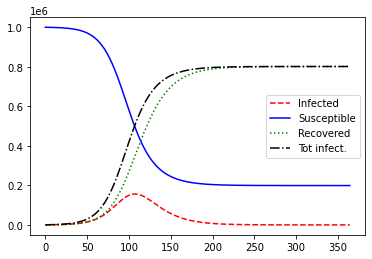

In [4]:
i_0 = 0.0005
N = int(10**6)
steps = 365

plot_sir(N, i_0)

The number of infections looks like bell curve and the cumulative number of infections looks like a CDF (but only reaches about 80%, rather than 100%.

The cumulative number is "sigmoidal" (vaguely "S"-shaped) in this example. You might imagine fitting a scaled CDF to the curve. Essentially, that is the IHME model.

What if immunity wears off over time? Let's try a positive value of $\delta$:

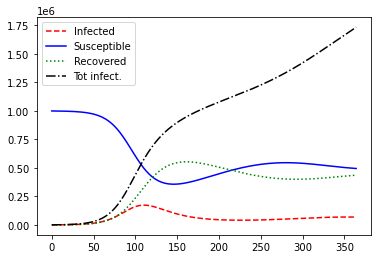

In [5]:
plot_sir(N, i_0, delta=0.01)

In [6]:
interact(plot_sir, N=fixed(N),
                   i_0 = widgets.FloatSlider(min=0, max=1, value=i_0),
                   beta=widgets.FloatSlider(value=2/14, min=0.01, max=100),
                   gamma=widgets.FloatSlider(value=1/14, min=0, max=1, step=0.01),
                   delta=widgets.FloatSlider(value=0, min=0, max=1, step=0.01),
                   steps=fixed(steps),
                   verbose=fixed(False))

interactive(children=(FloatSlider(value=0.0005, description='i_0', max=1.0), FloatSlider(value=0.1428571428571…

<function __main__.plot_sir(N, i_0, beta=0.14285714285714285, gamma=0.07142857142857142, delta=0, steps=365, verbose=False)>

## Fitting the SIR model to data

Now we will use least squares to fit the SIR model to a time history of infection data collected by researchers at Johns Hopkins University.See https://github.com/CSSEGISandData


This exercise is for illustration. There are many reasons to be wary of this modeling:

+ There are serious issues with the data quality: these are cases that were _reported_ according to the rules and circumstances of where they were detected. For mortality (rather than incidence), excess mortality might give a more accurate measure.
+ The model is a cartoon, not "physics" of epidemics, and it omits many factors that plausibly matter. It is not clear what estimates of the parameters mean when the model is wrong.
+ Absent a trustworthy generative model for the data, it is not clear how to assess or interpret the uncertainty of the estimates.
+ If the estimated model is to be used for prediction, there is no obvious way to assign meaningful uncertainties to the predictions.
+ The optimization problem to fit the parameters has no statistical content or motivation. It is not clear that it yields an estimate that is "good" in a useful sense. 
+ The objective function is not convex in the model parameters, and the optimization algorithm is not guaranteed to solve the optimization problem.

The data record total "confirmed" cases as a function of time, deaths, and recoveries: $C(t)$

In [7]:
from scipy.optimize import curve_fit

def f(x, beta, gamma):
    '''
    Model cumulative infections
    '''    
    return sir_model(N, i_0, beta, gamma, delta=0, steps=len(x))[3]

In [8]:
# test f
N = int(10**6)
i_0 = 0.0005
x = range(25)
y = f(x, 1/7, 1/14 )
y

array([ 500.        ,  571.39285714,  647.87464122,  729.80689646,
        817.5766761 ,  911.59831599, 1012.31532767, 1120.20241833,
       1235.76764552, 1359.55471484, 1492.14542917, 1634.1622985 ,
       1786.27131969, 1949.18493587, 2123.66518564, 2310.5270524 ,
       2510.64202461, 2724.94187786, 2954.42268994, 3200.14910031,
       3463.25882519, 3744.96743963, 4046.57343789, 4369.46358264,
       4715.11855381])

In [9]:
# test curve_fit
popt, pvoc = curve_fit(f, x, y, p0=[1, 0.5], bounds = (0, [np.inf, 1]))
popt

array([0.14285714, 0.07142857])

In [10]:
# try some real data from the JHU site
import pandas as pd
# data for countries
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                 sep=",")

In [11]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,8682,8818,8868,8946,9038,9083,9083,9194,9308,9379
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,18343,18425,18613,18679,18765,18875,18926,19011,19093,19177


In [12]:
# data for Denmark
DK = df.loc[(df["Country/Region"] == "Denmark") & df["Province/State"].isna()]
DK = DK.drop(['Province/State','Country/Region','Lat','Long'], axis=1).T
y = DK.to_numpy()
y = y[np.nonzero(y)]
x = range(len(y))
print(len(y),y)

330 [     1      1      3      4      4      6     10     10     23     23
     35     90    262    442    615    801    827    864    914    977
   1057   1151   1255   1326   1395   1450   1591   1724   1877   2046
   2201   2395   2577   2860   3107   3386   3757   4077   4369   4681
   5071   5402   5635   5819   5996   6174   6318   6511   6681   6879
   7073   7242   7384   7515   7695   7912   8073   8210   8445   8575
   8698   8851   9008   9158   9311   9407   9523   9670   9821   9938
  10083  10218  10319  10429  10513  10591  10667  10713  10791  10858
  10927  10968  11044  11117  11182  11230  11289  11360  11387  11428
  11480  11512  11593  11633  11669  11699  11734  11771  11811  11875
  11924  11948  11962  12001  12016  12035  12099  12139  12193  12217
  12250  12294  12344  12391  12391  12391  12527  12561  12615  12636
  12675  12675  12675  12751  12768  12794  12815  12832  12832  12832
  12878  12888  12900  12916  12946  12946  12946  13037  13061  13092
  

Text(0.5, 0, 'Days since first detected case')

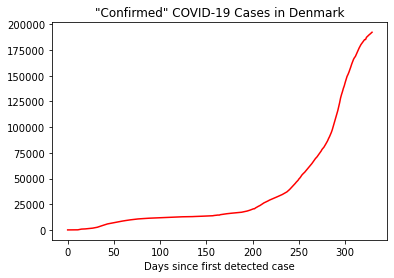

In [13]:
plt.plot(x,y, linestyle='-', color='r')
plt.title('"Confirmed" COVID-19 Cases in Denmark')
plt.xlabel('Days since first detected case')

In [14]:
N = 5792202 # estimated population of DK in 2020
i_0 = y[0]/N # initial prevalence
x = range(len(y))

In [15]:
# fit the model by nonlinear least squares
popt, pvoc = curve_fit(f, x, y, p0=[1, 0.5], bounds = (0, [500, 1]), maxfev=10000)
popt

array([1.02978587, 1.        ])

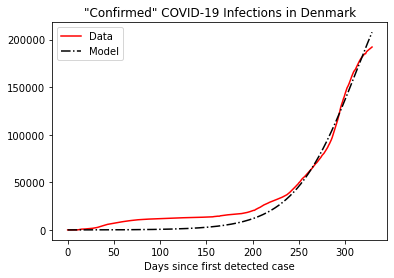

In [16]:
S, I, R, C = sir_model(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=len(y))
times = list(range(len(y)))
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, y, linestyle='-', color='r', label='Data')
ax.plot(times, C, linestyle='-.', color='k', label='Model')
ax.legend(loc='best')
plt.xlabel('Days since first detected case')
plt.title('"Confirmed" COVID-19 Infections in Denmark')
plt.show()

What happens if we run the model into the future?

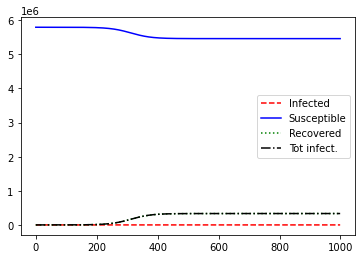

In [17]:
plot_sir(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=1000)


The total number of infections stabilizes, and the pandemic abates. The effective reproductive number $R_0$ is less than 1.

Let's do a quick sanity check.
Recall that $R_0 = \beta/\gamma$ for the SIR model _initially_, when the number infected, recovered, or dead are negligible compared to the total population.
Once some of the population has recovered, some of the people an infectious person encounters wiil be people who have recovered and not susceptible to reinfection (according to the model).
To first order, $\beta$ is effectively reduced by $S/N$.

In [18]:
popt[0]/popt[1] # greater than 1. According to the model, the infection will spread if R_0 > 1.

1.029785873622312

In [19]:
S, I, R, C = sir_model(N, i_0, beta=popt[0], gamma=popt[1], delta=0, steps=1000)
(S[-1]/N)*popt[0]/popt[1] # less than 1: According to the model, the infection will abate.

0.9705011201723404